# Ch4 | Transformer Block：搭建现代 LLM 积木

---

**目标：** 理解 Transformer 的核心组件

**核心问题：** 如何把 Attention 和 MLP 组合成强大的模型？

---

## 本章内容

1. **残差连接 (Residual)**：梯度的高速公路
2. **LayerNorm**：数据的归一化处理
3. **FFN/MLP**：模型的"记忆区"
4. **完整 Block**：组装 Transformer 积木

---

## 🎓 前置知识：从 Attention 到完整的 Transformer

### 回顾：Self-Attention 能做什么？

上一章我们学习了 Self-Attention：

```
输入序列 → Self-Attention → 每个词都"看过"其他词的输出
```

但只有 Attention 是不够的！还需要：

1. **非线性变换**：Attention 本质是加权求和（线性的），需要非线性才能学习复杂模式
2. **稳定训练**：深层网络容易出现梯度消失/爆炸
3. **信息保留**：深层网络可能丢失原始信息

### Transformer Block 的组件

一个完整的 Transformer Block 包含：

```
输入
  ↓
LayerNorm → 归一化，稳定训练
  ↓
Self-Attention → 学习词之间的关系
  ↓
残差连接 → 保留原始信息
  ↓
LayerNorm → 再次归一化
  ↓
FFN (前馈网络) → 引入非线性
  ↓
残差连接 → 再次保留信息
  ↓
输出
```

### 为什么需要残差连接？

**问题**：深层网络（比如100层）训练时，梯度会逐层变小，最终消失

**解决**：残差连接让梯度有"直通道"

```python
# 没有残差：梯度要经过每一层变换
output = layer(x)

# 有残差：梯度可以直接流过
output = layer(x) + x  # 这个 +x 就是残差连接
```

### 本章目标

- 理解残差连接如何解决梯度消失
- 理解 LayerNorm 的作用
- 理解 FFN/MLP 的作用
- 组装完整的 Transformer Block

## 0. 环境准备

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu128


---

## 1. 残差连接 (Residual Connection)

### 为什么需要残差连接？

深度网络的问题：
- 梯度消失：梯度在反向传播时越来越小
- 退化问题：网络越深，训练效果反而变差

### 解决方案

```
output = layer(x) + x  # 残差连接
```

这样梯度可以"直通"到底层，不经过任何变换！

![resnet_kaiming](resnet_kaiming.png)


In [19]:
class ResidualBlock(nn.Module):
    """演示残差连接"""
    def __init__(self, d_model):
        super().__init__()
        self.linear = nn.Linear(d_model, d_model)
    
    def forward(self, x):
        # 没有残差连接
        # return self.linear(x)
        
        # 有残差连接
        return self.linear(x) + x  # 关键！

# 对比梯度流动
d_model = 64
x = torch.randn(1, 10, d_model, requires_grad=True)

# 堆叠多层
layers_no_residual = nn.Sequential(*[nn.Linear(d_model, d_model) for _ in range(10)])
layers_with_residual = nn.ModuleList([ResidualBlock(d_model) for _ in range(10)])

# 无残差
out_no_res = x.clone()
for layer in layers_no_residual:
    out_no_res = layer(out_no_res)
loss_no_res = out_no_res.sum()
loss_no_res.backward()

print("无残差连接:")
print(f"  输出范围: [{out_no_res.min().item():.2f}, {out_no_res.max().item():.2f}]")

# 有残差
x2 = torch.randn(1, 10, d_model, requires_grad=True)
out_res = x2.clone()
for layer in layers_with_residual:
    out_res = layer(out_res)
loss_res = out_res.sum()
loss_res.backward()

print("\n有残差连接:")
print(f"  输出范围: [{out_res.min().item():.2f}, {out_res.max().item():.2f}]")
print("\n残差连接让信号更稳定！")

无残差连接:
  输出范围: [-0.17, 0.22]

有残差连接:
  输出范围: [-14.80, 13.94]

残差连接让信号更稳定！


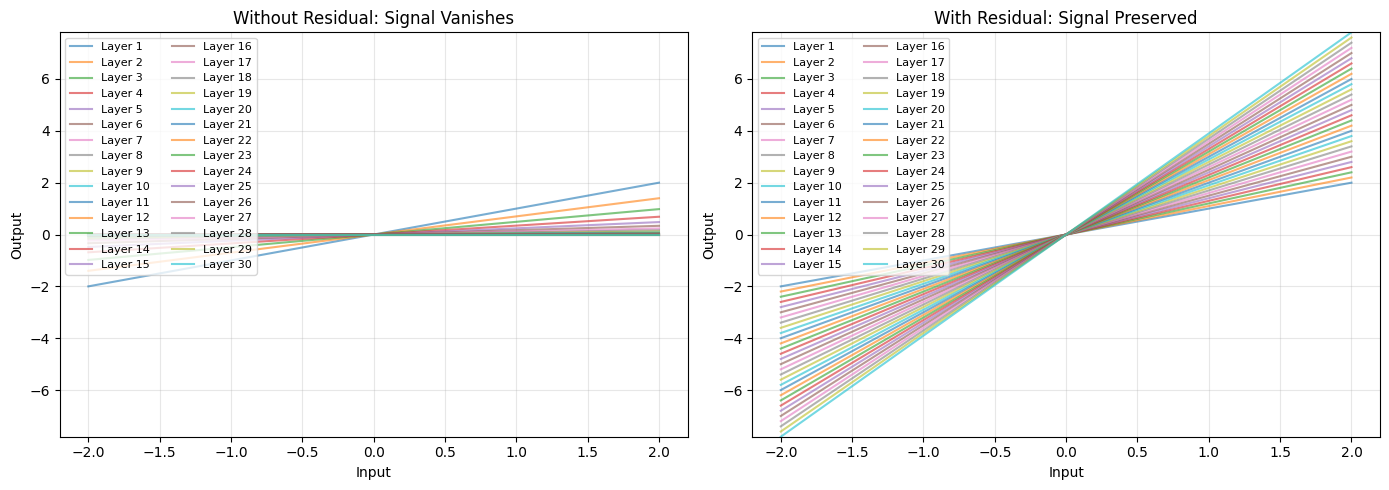

In [20]:
# 可视化残差连接
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n_layers = 30
decay = 0.7
residual_gain = 0.1
x = np.linspace(-2, 2, 100)

# 无残差：信号可能爆炸或消失
for i in range(n_layers):
    y = x * (decay ** i)  # 每层缩小
    axes[0].plot(x, y, label=f'Layer {i+1}', alpha=0.6)
axes[0].set_title('Without Residual: Signal Vanishes')
axes[0].set_xlabel('Input')
axes[0].set_ylabel('Output')
axes[0].legend(ncol=2, fontsize=8)
axes[0].grid(True, alpha=0.3)

# 有残差：信号保持
for i in range(n_layers):
    y = x * (1 + residual_gain * i)  # 残差叠加
    axes[1].plot(x, y, label=f'Layer {i+1}', alpha=0.6)
axes[1].set_title('With Residual: Signal Preserved')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output')
axes[1].legend(ncol=2, fontsize=8)
axes[1].grid(True, alpha=0.3)

max_abs = np.max(np.abs(x)) * (1 + residual_gain * (n_layers - 1))
for ax in axes:
    ax.set_ylim(-max_abs, max_abs)

plt.tight_layout()
plt.show()

---

## 2. Layer Normalization（层归一化）

### 为什么需要归一化？

- 让数据分布更稳定
- 加速训练收敛
- 减少对初始化的敏感性

### LayerNorm vs BatchNorm

```
BatchNorm: 在 batch 维度归一化（需要大 batch）
LayerNorm: 在 feature 维度归一化（适合序列模型）
```


In [21]:
class LayerNorm(nn.Module):
    """手写 LayerNorm"""
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        # 可学习的缩放和偏移参数
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
    
    def forward(self, x):
        # x: [batch, seq_len, d_model]
        
        # 在最后一个维度计算均值和方差
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        # 归一化
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
        # 缩放和偏移
        return self.gamma * x_norm + self.beta

# 测试
x = torch.randn(2, 5, 64) * 10 + 5  # 均值不为0，方差不为1

layer_norm = LayerNorm(64)
x_normed = layer_norm(x)

print("归一化前:")
print(f"  均值: {x.mean(dim=-1)[0]}")
print(f"  方差: {x.var(dim=-1)[0]}")

print("\n归一化后:")
print(f"  均值: {x_normed.mean(dim=-1)[0]}")  # 接近0
print(f"  方差: {x_normed.var(dim=-1)[0]}")   # 接近1

归一化前:
  均值: tensor([5.3953, 6.0928, 6.6541, 4.2342, 6.5122])
  方差: tensor([108.4763,  95.0552,  71.6612,  92.1775,  98.1938])

归一化后:
  均值: tensor([-1.4901e-08, -1.1176e-08, -1.1176e-08,  3.7253e-08, -1.8626e-09],
       grad_fn=<SelectBackward0>)
  方差: tensor([1.0159, 1.0159, 1.0159, 1.0159, 1.0159], grad_fn=<SelectBackward0>)


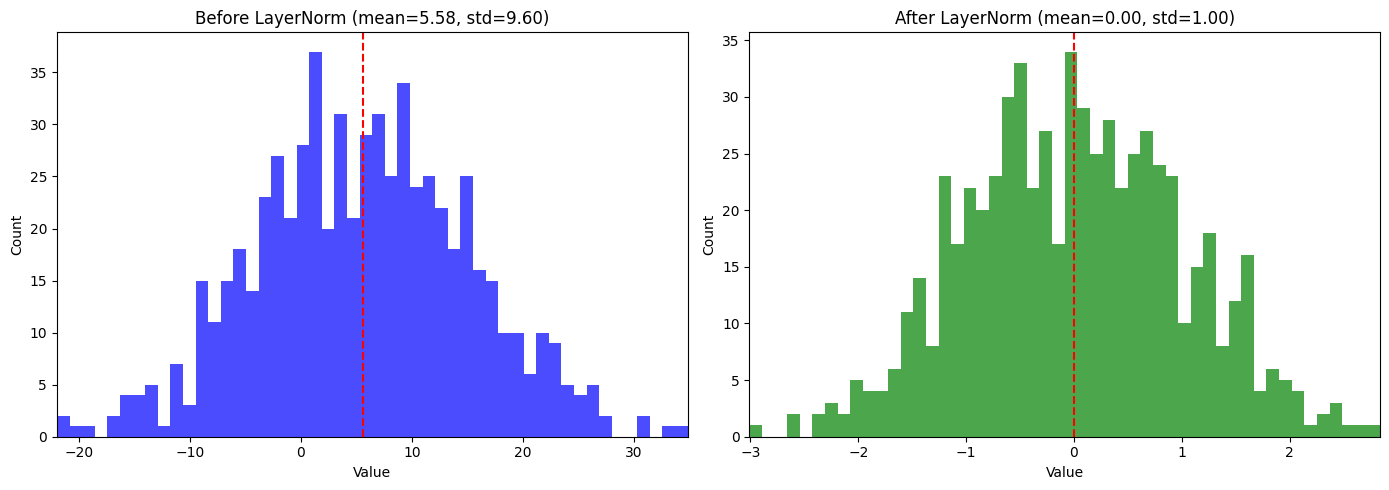

LayerNorm 让数据分布标准化（均值0，方差1）


In [23]:
# 可视化 LayerNorm 效果
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

raw_vals = x.detach().numpy().ravel()
norm_vals = x_normed.detach().numpy().ravel()
raw_mean = raw_vals.mean()
raw_std = raw_vals.std()
norm_mean = norm_vals.mean()
norm_std = norm_vals.std()
raw_min, raw_max = raw_vals.min(), raw_vals.max()
norm_min, norm_max = norm_vals.min(), norm_vals.max()

# 归一化前的分布
axes[0].hist(raw_vals, bins=50, alpha=0.7, color='blue', range=(raw_min, raw_max))
axes[0].set_title(f'Before LayerNorm (mean={raw_mean:.2f}, std={raw_std:.2f})')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Count')
axes[0].axvline(x=raw_mean, color='red', linestyle='--', label='Mean')

# 归一化后的分布
axes[1].hist(norm_vals, bins=50, alpha=0.7, color='green', range=(norm_min, norm_max))
axes[1].set_title(f'After LayerNorm (mean={norm_mean:.2f}, std={norm_std:.2f})')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Count')
axes[1].axvline(x=norm_mean, color='red', linestyle='--', label='Mean')

axes[0].set_xlim(raw_min, raw_max)
axes[1].set_xlim(norm_min, norm_max)

plt.tight_layout()
plt.show()

print("LayerNorm 让数据分布标准化（均值0，方差1）")

---

## 3. 前馈网络（FFN/MLP）

Transformer 中的 FFN 就是一个简单的两层 MLP：

```
FFN(x) = GELU(xW? + b?)W? + b?
```

特点：
- 先升维（通常 4x）
- 激活函数
- 再降维


In [24]:
class FeedForward(nn.Module):
    """Transformer 中的 FFN"""
    def __init__(self, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model  # 默认4倍扩展
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # 升维 -> 激活 -> 降维
        x = self.linear1(x)
        x = F.gelu(x)  # 现代LLM常用GELU
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# 测试
ffn = FeedForward(d_model=64, d_ff=256)
x = torch.randn(2, 10, 64)
out = ffn(x)

print(f"输入: {x.shape}")
print(f"中间层: [2, 10, 256]  (4x扩展)")
print(f"输出: {out.shape}")
print(f"\n参数量: {sum(p.numel() for p in ffn.parameters()):,}")

输入: torch.Size([2, 10, 64])
中间层: [2, 10, 256]  (4x扩展)
输出: torch.Size([2, 10, 64])

参数量: 33,088


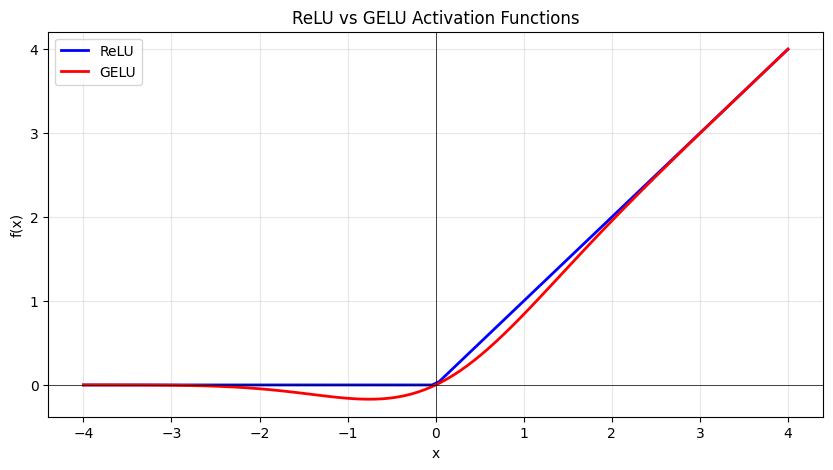

GELU 在负数区域有小的负值，比 ReLU 更平滑


In [25]:
# 可视化 GELU vs ReLU
x = np.linspace(-4, 4, 100)

plt.figure(figsize=(10, 5))
plt.plot(x, np.maximum(0, x), 'b-', linewidth=2, label='ReLU')
plt.plot(x, x * 0.5 * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3))), 
         'r-', linewidth=2, label='GELU')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('ReLU vs GELU Activation Functions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.show()

print("GELU 在负数区域有小的负值，比 ReLU 更平滑")

---

## 4. 完整的 Transformer Block

现在把所有组件拼装在一起！

### Pre-LN vs Post-LN（前归一化 vs 后归一化）

```
Post-LN (原始):  x + LayerNorm(Attention(x))
Pre-LN (现代):   x + Attention(LayerNorm(x))
```

现代 LLM（GPT-2/3, LLaMA）都用 Pre-LN，训练更稳定。


In [26]:
class MultiHeadAttention(nn.Module):
    """多头注意力（简化版）"""
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_qkv = nn.Linear(d_model, 3 * d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        B, T, C = x.shape
        
        # 一次性计算 Q, K, V
        qkv = self.W_qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)
        
        # 分头
        q = q.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        
        # 注意力
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        # 输出
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.W_o(out)

In [27]:
class TransformerBlock(nn.Module):
    """
    完整的 Transformer Block (Pre-LN 版本)
    
    结构:
    x -> LayerNorm -> Attention -> + -> LayerNorm -> FFN -> +
         |__________________________|    |___________________|
                残差连接                       残差连接
    """
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        
        # Layer Norms
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        
        # Attention
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Feed Forward
        self.ffn = FeedForward(d_model, d_ff, dropout)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Attention block with residual
        x = x + self.dropout(self.attention(self.ln1(x), mask))
        
        # FFN block with residual
        x = x + self.dropout(self.ffn(self.ln2(x)))
        
        return x

# 创建并测试
block = TransformerBlock(d_model=64, n_heads=8, d_ff=256)
x = torch.randn(2, 10, 64)
out = block(x)

print("Transformer Block:")
print(f"  输入: {x.shape}")
print(f"  输出: {out.shape}")
print(f"  参数量: {sum(p.numel() for p in block.parameters()):,}")

Transformer Block:
  输入: torch.Size([2, 10, 64])
  输出: torch.Size([2, 10, 64])
  参数量: 49,984


In [28]:
# 打印模型结构
print("TransformerBlock 结构:")
print("=" * 60)
for name, module in block.named_children():
    print(f"{name}: {module.__class__.__name__}")
    if hasattr(module, 'weight'):
        print(f"    shape: {module.weight.shape}")
print("=" * 60)

TransformerBlock 结构:
ln1: LayerNorm
    shape: torch.Size([64])
ln2: LayerNorm
    shape: torch.Size([64])
attention: MultiHeadAttention
ffn: FeedForward
dropout: Dropout


---

## 5. 堆叠多个 Block

真正的 Transformer 是多个 Block 堆叠。

In [29]:
class Transformer(nn.Module):
    """堆叠多个 Transformer Block"""
    def __init__(self, n_layers, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.ln_final = nn.LayerNorm(d_model)
    
    def forward(self, x, mask=None):
        for block in self.blocks:
            x = block(x, mask)
        return self.ln_final(x)

# 创建一个 6 层 Transformer
model = Transformer(
    n_layers=6,
    d_model=64,
    n_heads=8,
    d_ff=256
)

x = torch.randn(2, 10, 64)
out = model(x)

print(f"6层 Transformer:")
print(f"  输入: {x.shape}")
print(f"  输出: {out.shape}")
print(f"  总参数量: {sum(p.numel() for p in model.parameters()):,}")

6层 Transformer:
  输入: torch.Size([2, 10, 64])
  输出: torch.Size([2, 10, 64])
  总参数量: 300,032


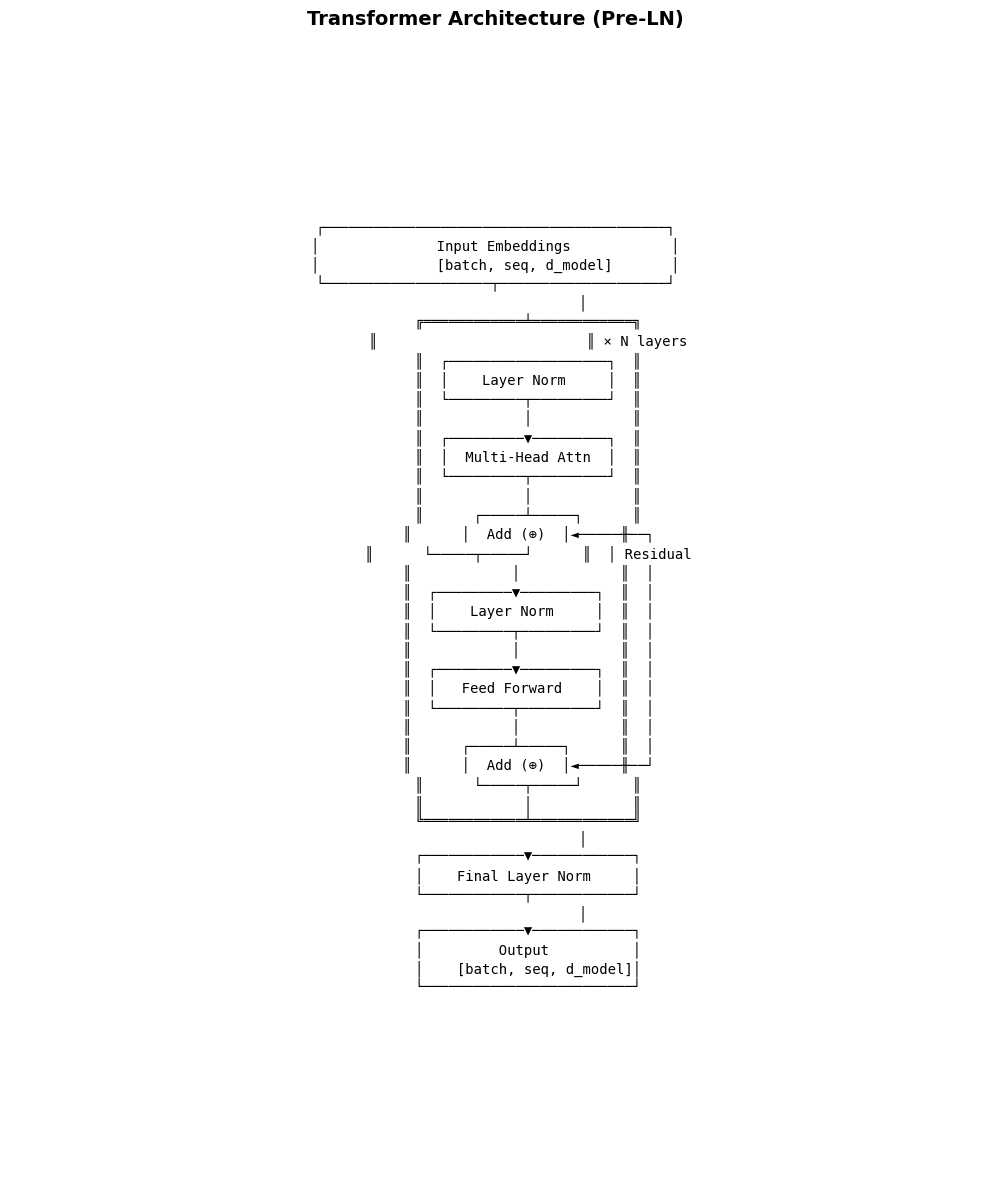

In [30]:
# 可视化 Transformer 结构
fig, ax = plt.subplots(figsize=(10, 12))
ax.axis('off')

# 绘制结构图
structure = '''
┌─────────────────────────────────────────┐
│              Input Embeddings            │
│              [batch, seq, d_model]       │
└────────────────────┬────────────────────┘
                     │
        ╔════════════╧════════════╗
        ║                         ║ × N layers
        ║  ┌───────────────────┐  ║
        ║  │    Layer Norm     │  ║
        ║  └─────────┬─────────┘  ║
        ║            │            ║
        ║  ┌─────────▼─────────┐  ║
        ║  │  Multi-Head Attn  │  ║
        ║  └─────────┬─────────┘  ║
        ║            │            ║
        ║      ┌─────┴─────┐      ║
        ║      │  Add (⊕)  │◄─────╫──┐
        ║      └─────┬─────┘      ║  │ Residual
        ║            │            ║  │
        ║  ┌─────────▼─────────┐  ║  │
        ║  │    Layer Norm     │  ║  │
        ║  └─────────┬─────────┘  ║  │
        ║            │            ║  │
        ║  ┌─────────▼─────────┐  ║  │
        ║  │   Feed Forward    │  ║  │
        ║  └─────────┬─────────┘  ║  │
        ║            │            ║  │
        ║      ┌─────┴─────┐      ║  │
        ║      │  Add (⊕)  │◄─────╫──┘
        ║      └─────┬─────┘      ║
        ║            │            ║
        ╚════════════╧════════════╝
                     │
        ┌────────────▼────────────┐
        │    Final Layer Norm     │
        └────────────┬────────────┘
                     │
        ┌────────────▼────────────┐
        │         Output          │
        │    [batch, seq, d_model]│
        └─────────────────────────┘
'''
ax.text(0.5, 0.5, structure, fontsize=10, family='monospace',
        ha='center', va='center', transform=ax.transAxes)
plt.title('Transformer Architecture (Pre-LN)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 本章总结


1. **残差连接**
   - `output = layer(x) + x`
   - 解决梯度消失和退化问题
   - 让深度网络成为可能

2. **LayerNorm**
   - 在特征维度归一化
   - 稳定训练过程
   - Pre-LN 比 Post-LN 更稳定

3. **FFN/MLP**
   - 先升维（4x）再降维
   - 使用 GELU 激活函数
   - 模型的主要参数所在

4. **Transformer Block**
   - Attention + FFN + 残差 + LayerNorm
   - 现代 LLM 的基本积木


---

## 思考

1. **对比 Pre-LN 和 Post-LN**：实现两种版本，比较训练稳定性
2. **改变 FFN 维度**：尝试不同的扩展比例（2x, 4x, 8x）
3. **思考题**：为什么 Attention 参数量比 FFN 少，但同样重要？

In [17]:
# 练习空间

